In [9]:
import os
import sys
#sys.path.insert(1, '../Src/')
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from umap import UMAP
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

PATH_DATA = '../../Data'

np.random.seed(42)

%matplotlib inline

In [10]:
pip install umap-learn

You should consider upgrading via the '/media/cristian/Extreme SSD/Investigacion/NMA/nma_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [11]:
fname = "stringer_spontaneous.npy"
fname =os.path.join(PATH_DATA,fname)

In [12]:
# @title Data loading
dat = np.load(fname, allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


# neural activity vs run

In [13]:
X = dat['sresp'].T
X.shape

(7018, 11983)

In [14]:
X[0,:10]

array([ 2.9820833,  5.001608 ,  7.6890087,  7.469154 , 10.461974 ,
        0.9270815, 50.33032  , 30.159632 ,  8.333404 ,  0.       ],
      dtype=float32)

In [15]:
y = dat['run']

y[:10]

array([[ 0.04362508],
       [ 5.68850741],
       [ 9.13091541],
       [16.93934616],
       [17.46566997],
       [18.24205322],
       [13.97415054],
       [12.0409406 ],
       [ 7.73315837],
       [ 1.6310023 ]])

### Normalization

In [16]:
X = (X-X.mean())/X.std()

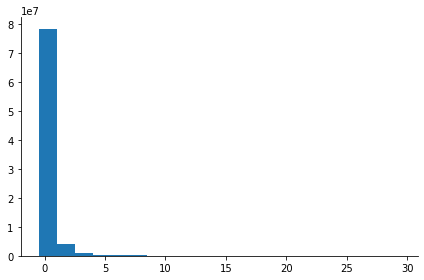

In [17]:
hist = plt.hist(X.flatten(),bins=20)

In [18]:

n = int(len(X)*0.3)

X_train = X[:-n]
y_train = y[:-n]

X_test  = X[-n:]
y_test  = y[-n:]
print('Train : ',X_train.shape)
print('Test  : ',X_test.shape)

Train :  (4913, 11983)
Test  :  (2105, 11983)


## Dimensionality reduction with PCA

In [19]:
my_model = PCA() #n_components=3000
my_model.fit_transform(X_train)

array([[ 3.67771626e+00, -1.21858768e+01,  7.13502121e+00, ...,
        -6.49377406e-02,  6.19525552e-01,  3.45235778e-04],
       [ 2.68574734e+01, -4.79210663e+00, -6.41352987e+00, ...,
         3.31490450e-02, -1.77332491e-01,  3.44924134e-04],
       [ 2.11890278e+01,  2.28503895e+00,  2.79125333e+00, ...,
        -6.86706230e-02, -1.73593968e-01,  3.45188018e-04],
       ...,
       [-1.42318468e+01, -1.16335945e+01, -2.04181023e+01, ...,
        -5.36085740e-02, -1.92133456e-01,  3.45174019e-04],
       [-1.02467861e+01, -9.51379299e+00, -1.76687565e+01, ...,
        -9.41334590e-02,  1.28939360e-01,  3.45190754e-04],
       [-6.27216721e+00, -1.33489332e+01, -1.30418215e+01, ...,
         1.19754963e-01,  1.04842797e-01,  3.45247419e-04]], dtype=float32)

In [23]:
explained_variance_ratio_ = my_model.explained_variance_ratio_
print(explained_variance_ratio_.shape)

(4913,)


In [24]:
explained_variance_ratio_[:4]

array([0.02549715, 0.02328681, 0.01812443, 0.01412791], dtype=float32)

Text(0, 0.5, 'explained_variance_ratio_')

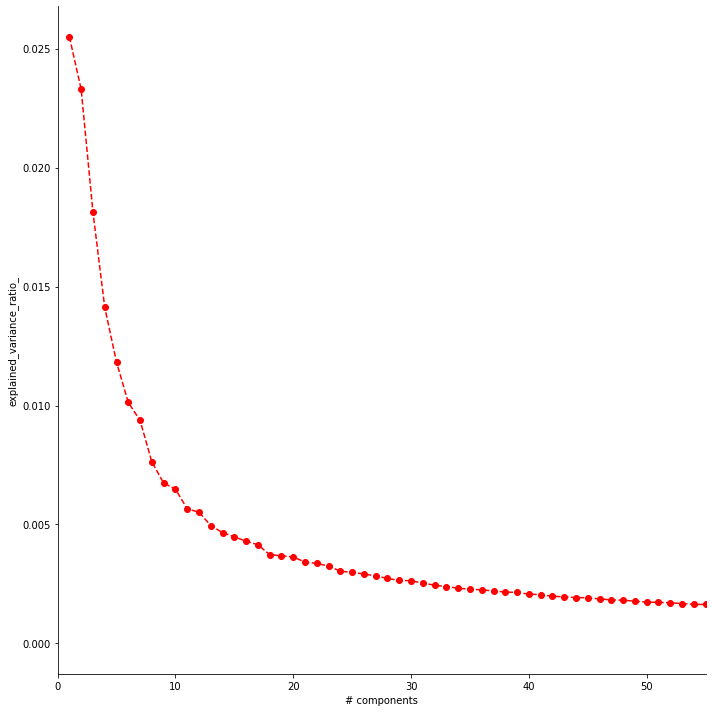

In [25]:
fig = plt.figure(figsize=(10,10))

plt.plot(range(1,len(explained_variance_ratio_)+1),explained_variance_ratio_,'--ro')
plt.xlim(0,55) 
plt.xlabel("# components")
plt.ylabel("explained_variance_ratio_")

In [26]:
accumulate_explained_variance_ratio_ = np.cumsum(explained_variance_ratio_)

In [27]:
accumulate_explained_variance_ratio_[:4]

array([0.02549715, 0.04878395, 0.06690837, 0.08103628], dtype=float32)

Text(0, 0.5, 'sum explained_variance_ratio')

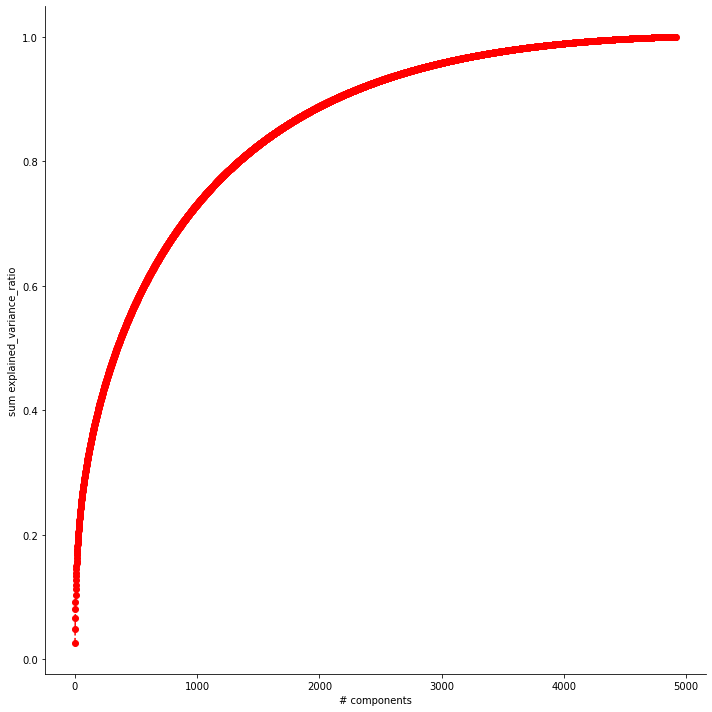

In [28]:
fig = plt.figure(figsize=(10,10))

plt.plot(range(1,len(accumulate_explained_variance_ratio_)+1),accumulate_explained_variance_ratio_,'--ro')

plt.xlabel("# components")
plt.ylabel("sum explained_variance_ratio")

### 2000 first components

In [29]:
accumulate_explained_variance_ratio_[2000]

0.88826877

In [30]:
print('Train : ',X_train.shape)
print('Test  : ',X_test.shape)

Train :  (4913, 11983)
Test  :  (2105, 11983)


In [31]:
X_train_pca = my_model.transform(X_train)[:,:2000]
X_test_pca  = my_model.transform(X_test)[:,:2000]

In [33]:
print('Train PCA : ',X_train_pca.shape)
print('Test PCA  : ',X_test_pca.shape)

Train PCA :  (4913, 2000)
Test PCA  :  (2105, 2000)


## Linear Regression with positive and negative coefficients

In [35]:
my_model_LR_1 = LinearRegression(positive=False)
#ElasticNet(alpha=0.1,l1_ratio=0.01,random_state=0)
my_model_LR_1.fit(X_train_pca,y_train)

LinearRegression()

metric_train_R2  : 0.9261667556481391
metric_train_RMSE: 1.8687132325130456
metric_test_R2  : 0.8427038056451991
metric_test_RMSE: 4.212303861417338


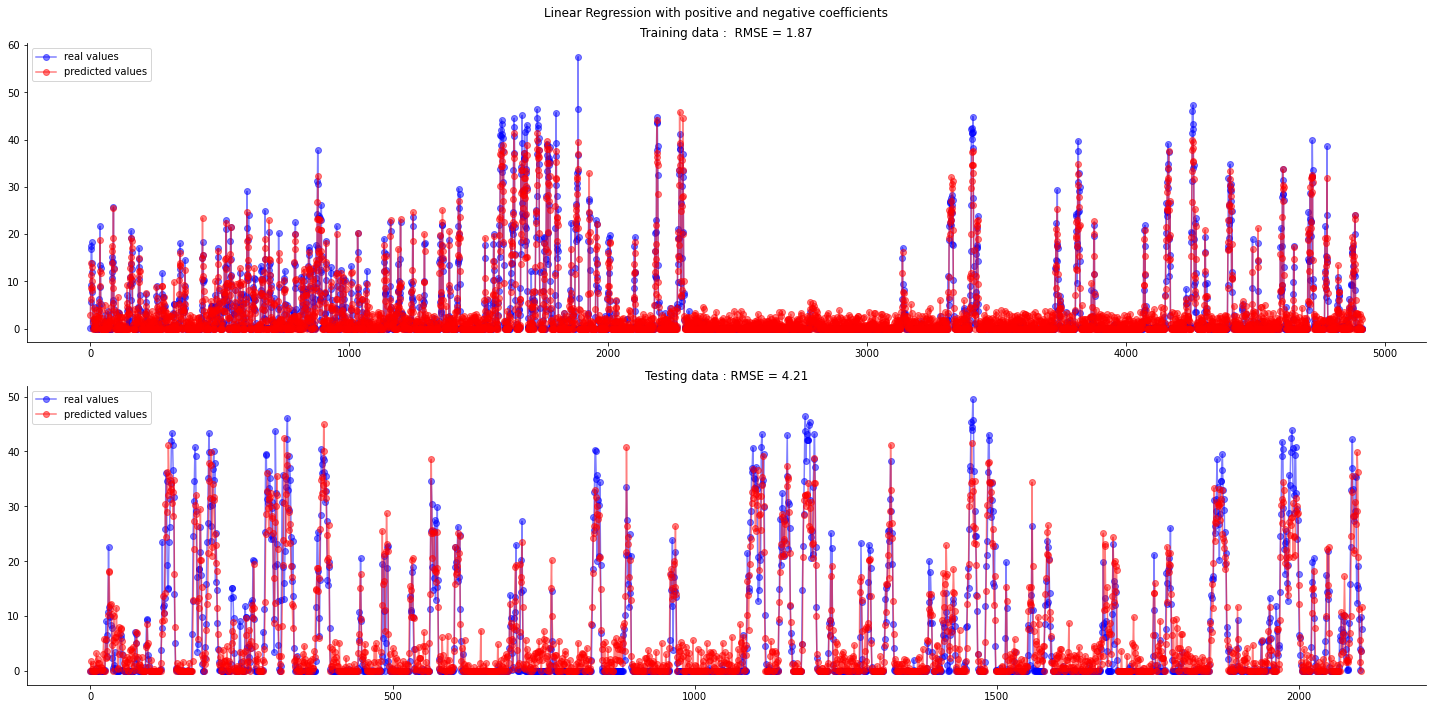

In [36]:
y_train_pred      = my_model_LR_1.predict(X_train_pca) # metric_train_RMSE: 2.4037369030804003e-05


y_train_pred[y_train_pred<=0] = 0  # metric_train_RMSE: 2.196909835364599e-05


metric_train_R2   = my_model_LR_1.score(X_train_pca, y_train)
metric_train_RMSE = mean_squared_error(y_train, y_train_pred, squared=False)

print("metric_train_R2  :",metric_train_R2)
print("metric_train_RMSE:",metric_train_RMSE)

fig = plt.figure(figsize=(20,10))


plt.subplot(2,1,1)
plt.plot(range(len(y_train)),y_train,'-bo',alpha=0.5,label='real values')
plt.plot(range(len(y_train_pred)),y_train_pred,'-ro',alpha=0.5,label='predicted values')

plt.legend(loc="upper left")
plt.title('Training data :  RMSE = '+str(np.round(metric_train_RMSE,2)))
#plt.show()


y_test_pred      = my_model_LR_1.predict(X_test_pca) # metric_test_RMSE: 5.73526388441703

y_test_pred[y_test_pred<=0] = 0 #metric_test_RMSE: 5.5218955408988


metric_test_R2   = my_model_LR_1.score(X_test_pca, y_test)
metric_test_RMSE = mean_squared_error(y_test, y_test_pred, squared=False)

print("metric_test_R2  :",metric_test_R2)
print("metric_test_RMSE:",metric_test_RMSE)

#fig = plt.figure(figsize=(20,5))
plt.subplot(2,1,2)
plt.plot(range(len(y_test)),y_test,'-bo',alpha=0.5,label='real values')
plt.plot(range(len(y_test_pred)),y_test_pred,'-ro',alpha=0.5,label='predicted values')
plt.title('Testing data : RMSE = '+str(np.round(metric_test_RMSE,2)))
plt.legend(loc="upper left")

plt.suptitle('Linear Regression with positive and negative coefficients')
plt.show()


In [22]:
%matplotlib inline

## Linear Regression with positive coefficients

In [23]:
my_model_LR_2 = LinearRegression(positive=True)# POSITIVE = False
my_model_LR_2.fit(X_train_pca,y_train)

LinearRegression(positive=True)

metric_train_R2  : 0.7052941276511429
metric_train_RMSE: 3.8411404347463574
metric_test_R2  : 0.6832505288737327
metric_test_RMSE: 6.103741364931081


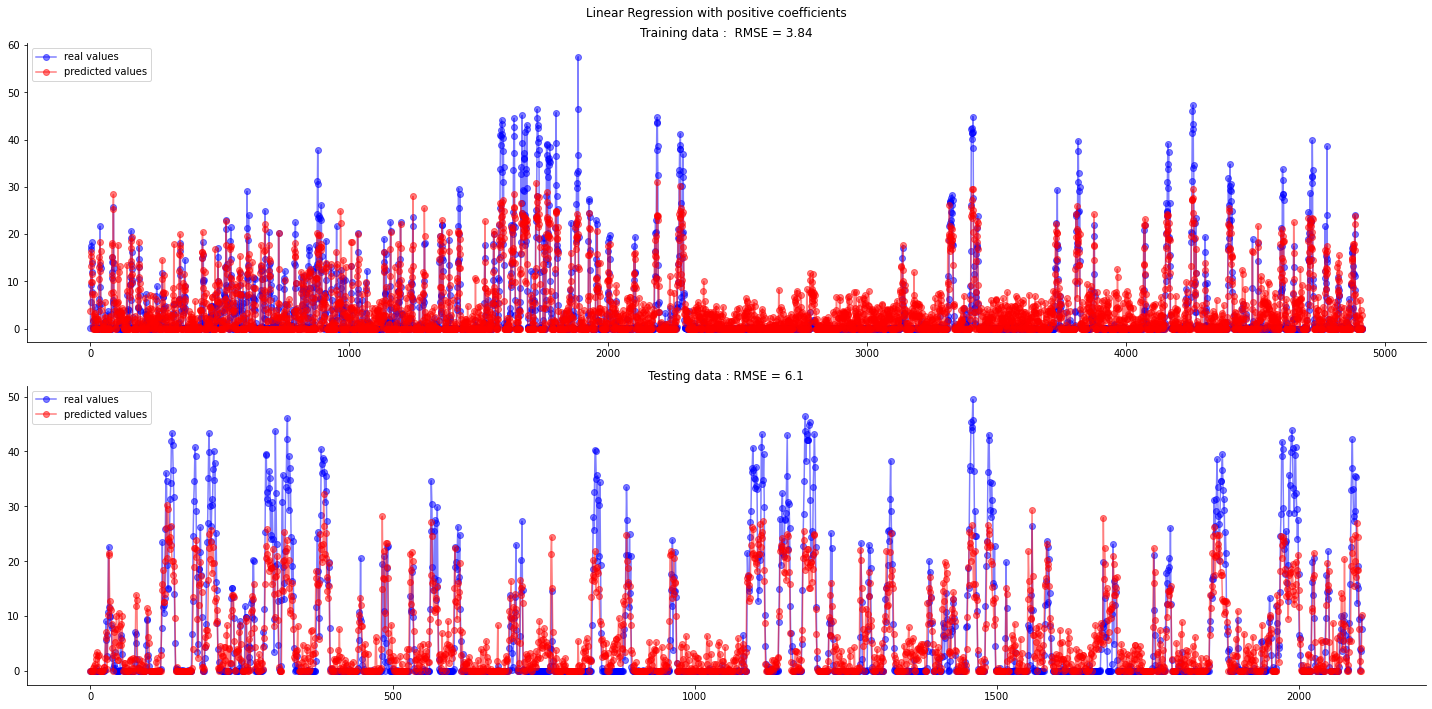

In [24]:
y_train_pred      = my_model_LR_2.predict(X_train_pca) # metric_train_RMSE: 2.4037369030804003e-05


y_train_pred[y_train_pred<=0] = 0  # metric_train_RMSE: 2.196909835364599e-05


metric_train_R2   = my_model_LR_2.score(X_train_pca, y_train)
metric_train_RMSE = mean_squared_error(y_train, y_train_pred, squared=False)

print("metric_train_R2  :",metric_train_R2)
print("metric_train_RMSE:",metric_train_RMSE)

fig = plt.figure(figsize=(20,10))


plt.subplot(2,1,1)
plt.plot(range(len(y_train)),y_train,'-bo',alpha=0.5,label='real values')
plt.plot(range(len(y_train_pred)),y_train_pred,'-ro',alpha=0.5,label='predicted values')

plt.legend(loc="upper left")
plt.title('Training data :  RMSE = '+str(np.round(metric_train_RMSE,2)))
#plt.show()


y_test_pred      = my_model_LR_2.predict(X_test_pca) # metric_test_RMSE: 5.73526388441703

y_test_pred[y_test_pred<=0] = 0 #metric_test_RMSE: 5.5218955408988


metric_test_R2   = my_model_LR_2.score(X_test_pca, y_test)
metric_test_RMSE = mean_squared_error(y_test, y_test_pred, squared=False)

print("metric_test_R2  :",metric_test_R2)
print("metric_test_RMSE:",metric_test_RMSE)

#fig = plt.figure(figsize=(20,5))
plt.subplot(2,1,2)
plt.plot(range(len(y_test)),y_test,'-bo',alpha=0.5,label='real values')
plt.plot(range(len(y_test_pred)),y_test_pred,'-ro',alpha=0.5,label='predicted values')
plt.title('Testing data : RMSE = '+str(np.round(metric_test_RMSE,2)))
plt.legend(loc="upper left")

plt.suptitle('Linear Regression with positive coefficients')
plt.show()
